##### Creating Dataset:
1. Downloaded twitter data in json file using twarc API. 
2. Used filter to download tweets that have sad and happy words as hashtag in tweets. 
3. There are two files happy.json and sad.json 
4. Read through each file line by line and extracted tweets. 
5. Go through each tweets and label them as per correspofing hashtag.

In [1]:
import json
import re, string
from random import shuffle


# Method that says if a given tweet is happy or sad according to the tweet
# 1 for Happy and 0 for Sad and -1 for neutral ( if tweet has both hashtag )
def sadOrHappyTweet(tweet):
    tweet = tweet.lower()
    sad = True if tweet.find('#sad') != -1 else False
    happy = True if '#happy' in tweet else False
    if(sad and happy):
        return -1
    elif(sad):
        return 0
    elif(happy):
        return 1 

# Reads tweets from given file and classified it and returns the list
def getTweets(fileName):
    tempTweets = []
    with open(fileName, 'r') as jFile:
        for line in jFile:
            lineTweet = json.loads(line)
            unProcessedTweet = lineTweet["full_text"];

            # Remove links from tweets
            unProcessedTweet = re.sub(r"http\S+", "", unProcessedTweet)

            # Removing mentions, any words that begins with '@'
            unProcessedTweet = re.sub("@([a-zA-Z0-9]{1,15})", "", unProcessedTweet)

            # Removing punctuation
            #unProcessedTweet = re.sub(r"[^\w\s]", "" ,unProcessedTweet)

            cl = sadOrHappyTweet(unProcessedTweet)            
            if cl == 1:
                tempTweets.append((unProcessedTweet, 1))
            elif cl == 0:
                tempTweets.append((unProcessedTweet, 0))
    return tempTweets;


#Read each file line by line and extract tweets and save it in sad_tweets and happy tweets ( 1 for happy and 0 for sad)
sad_tweets = getTweets('sad_tweets.jsonl')[0:21500]
happy_tweets = getTweets('happy_tweets.jsonl')[0:21500]

print(len(happy_tweets))
print(len(sad_tweets))


21500
21500


In [2]:
# Preprocess labelled tweets. 
# Remove happy and sad hashtag tweets
# Remove punctuations
# Remove pronouns, conjunctions, and words like 'a, am, are, the, has, have etc.'

import re

def preProcessTweets(tweet_col):
    temp_list = []
    for tw, label in tweet_col:
        tweet_words = tw.lower().split()
        tw_words_list = []
        for words in tweet_words:
            if(words == '#happy'):
                continue
            if(words == '#sad'):
                continue
            # Removing hash tag and taking it as normal word
            words.replace('#', '')
            
            # Removing punctuation
            words = re.sub(r'[^\w\s]','', words)
            
            if(len(words) > 3):
                tw_words_list.append(words)
        
        # Add the word list in temp list and return them
        temp_list.append(( ' '.join(tw_words_list), label))
    return temp_list

happy_tweets = preProcessTweets(happy_tweets)
sad_tweets = preProcessTweets(sad_tweets)

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Perform Multonomial bayesian classifier for given tweets.
# Create test set and training set
def performMultinomialNB(all_tweets):
    
    # Separating training set and test set
    total_tweets = len(all_tweets)
    training_set = all_tweets[0:int(total_tweets/2)]
    test_set = all_tweets[int(total_tweets/2):]
    
    all_tweets_list = [words for words, label in all_tweets ]
    all_tweets_labels = [label for words, label in all_tweets ]
    training_set_words, test_set_words, training_set_labels, test_set_labels = train_test_split(all_tweets_list, all_tweets_labels, test_size=0.4)
    
    # Train the Bayesian Classifier    
    #print("Size of training doc: ", len(training_set_words))
    #print("Size of test doc: ",len(test_set_words)) 

    count_vect = CountVectorizer()
    train_count_vect = count_vect.fit_transform(training_set_words)

    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_count_vect)
    #print(train_tfidf.shape)

    classifier = MultinomialNB().fit(train_tfidf, training_set_labels)
    #print(clf)
    
    # Now perform prediction using the test set
    
    #print(len(test_set_words))
    #print(len(test_set_labels))
    
    test_count_vect = count_vect.transform(test_set_words)
    test_tfidf = tfidf_transformer.transform(test_count_vect)
    #print(test_tfidf.shape)
    
    predicted = classifier.predict(test_tfidf)
    
    acc_mnb = np.mean(predicted == test_set_labels)
    #print("The accuracy using Multinomial Bayesian classifier for "+ str(2*size) " is " + str(acc_mnb))
    
    return acc_mnb

# Get happy and sad tweets and combine them and shuffle them
dataSize = [5000, 10000, 15000, 20000]
bayesian_results = {}
for size in dataSize:
    all_tweets = []
    all_tweets.extend(happy_tweets[:size])
    all_tweets.extend(sad_tweets[:size])
    shuffle(all_tweets)
    bayesian_results[2*size] = performMultinomialNB(all_tweets)

print(bayesian_results)

{10000: 0.90225, 20000: 0.88837500000000003, 30000: 0.88833333333333331, 40000: 0.89512499999999995}


{10000: [0.75175000000000003, 0.63324999999999998, 0.58250000000000002, 0.54500000000000004, 0.51600000000000001, 0.50124999999999997], 20000: [0.78200000000000003, 0.6915, 0.62924999999999998, 0.58850000000000002, 0.55125000000000002, 0.53549999999999998], 30000: [0.79741666666666666, 0.67574999999999996, 0.64575000000000005, 0.60741666666666672, 0.5665, 0.54249999999999998], 40000: [0.80056249999999995, 0.70868750000000003, 0.65475000000000005, 0.61668750000000006, 0.57162500000000005, 0.5440625]}


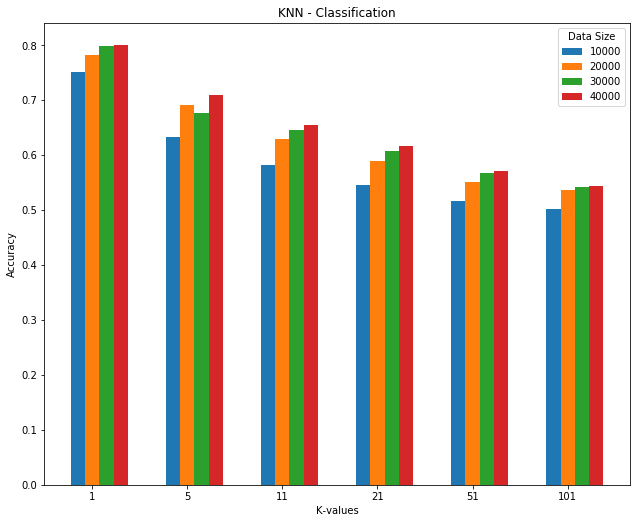

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

# Perform Support Vector Machine classifier for given tweets.
# Create test set and training set
def performKNN(all_tweets, size):
    
    # Separating training set and test set
    total_tweets = len(all_tweets)
    all_tweets_list = [words for words, label in all_tweets ]
    all_tweets_labels = [label for words, label in all_tweets ]
    training_set_words, test_set_words, training_set_labels, test_set_labels = train_test_split(all_tweets_list, all_tweets_labels, test_size=0.4)

    # K paramter to perform KNN
    k_values = [1, 5, 11, 21, 51, 101]
    
    count_vect = CountVectorizer()
    train_count_vect = count_vect.fit_transform(training_set_words)

    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_count_vect)
    
    test_count_vect = count_vect.transform(test_set_words)
    test_tfidf = tfidf_transformer.transform(test_count_vect)
    
    accuracy_result = []
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)

        # Using Training data
        classifier = knn.fit(train_tfidf, training_set_labels)
        predicted = classifier.predict(test_tfidf)
        accuracy_result.append(np.mean(predicted == test_set_labels))
        #print("Accuracy for k = " + str(k) + " using test set of "+ str(2*size) + " is : ", str(np.mean(predicted == test_set_labels)))
    return accuracy_result

def graphKNNAccuracy(dict, title):
    
    k_values = [1, 5, 11, 21, 51, 101]   
    N = 6
    ind = np.arange(N)
    width = 0.15

    fig = plt.figure()
    fig.set_size_inches(10.5, 8.5)
    ax = fig.add_subplot(111)
    
    rects = []
    i = 0
    for k, v in dict.items():
        rects.append(ax.bar(ind+width*i, v, width))
        i= i+1
    plt.title(title)
    ax.set_xlabel('K-values')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(ind+width)
    ax.set_xticklabels( [ k for k in k_values ] )
    ax.legend( [rect[0] for rect in rects], [k for k in dict.keys()], title="Data Size" )

    plt.show()
    fig.savefig('knn-result.png')

# Get happy and sad tweets and combine them and shuffle them
dataSize = [5000, 10000, 15000, 20000]
knn_results = {}
for size in dataSize:
    all_tweets = []
    all_tweets.extend(happy_tweets[:size])
    all_tweets.extend(sad_tweets[:size])
    shuffle(all_tweets)
    re = performKNN(all_tweets, 2*size)
    knn_results[2*size] = re

print(knn_results)
graphKNNAccuracy(knn_results, "KNN - Classification")
                   

In [6]:
# Use grid search to find best parameter
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def performGridSearchKNN(all_tweets):
        
    # Separating training set and test set
    total_tweets = len(all_tweets)
    all_tweets_list = [words for words, label in all_tweets ]
    all_tweets_labels = [label for words, label in all_tweets ]
    training_set_words, test_set_words, training_set_labels, test_set_labels = train_test_split(all_tweets_list, all_tweets_labels, test_size=0.4)
    
    print("Size of training doc: ", len(training_set_words))
    print("Size of test doc: ",len(test_set_words)) 
    
    # K paramter to perform KNN
    k_values = [1, 5, 11, 21, 51, 101]
    kvalue_dict = dict(KNeighborsClassifier__n_neighbors=k_values)

    # KNN classifier object, Count Vectorizer object and Pipeline
    '''count_vect = CountVectorizer()
    train_count_vect = count_vect.fit_transform(training_set_words)

    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_count_vect)
    
    test_count_vect = count_vect.transform(test_set_words)
    test_tfidf = tfidf_transformer.transform(test_count_vect)'''
    
    knn = KNeighborsClassifier()   # Just giving random k for a while
    cv = CountVectorizer()
    #tVector = TfidfVectorizer()
    #k_normalized_Pipeline = Pipeline([('CV', cv), ('tVector', tVector), ('KNeighborsClassifier',  knn)])
    kPipeline = Pipeline([('CV', cv), ('KNeighborsClassifier',  knn)])

    # Creating Grid Search object
    grid_search = GridSearchCV(kPipeline, kvalue_dict)
    grid_search.fit(training_set_words, training_set_labels)
    
    # Print the best k neighbor value with the best score
    print("The best score on training data is ", grid_search.best_score_ )
    print("The best parameter i.e., k-neighbor value is ", grid_search.best_estimator_.get_params()["KNeighborsClassifier__n_neighbors"])
    
    # Now predicting class label for test data and then getting the accuracy i.e., comparing with original one
    pred_result = grid_search.predict(test_set_words)
    print("The accuracy on test set is ", np.mean(pred_result == test_set_labels))

all_tweets = []
all_tweets.extend(happy_tweets[:20000])
all_tweets.extend(sad_tweets[:20000])
shuffle(all_tweets)
performGridSearchKNN(all_tweets)

Size of training doc:  24000
Size of test doc:  16000
The best score on training data is  0.8297916666666667
The best parameter i.e., k-neighbor value is  1
The accuracy on test set is  0.84525


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree

# Perform Support Vector Machine classifier for given tweets.
# Create test set and training set
def performDecisionTree(all_tweets):
    
    # Separating training set and test set
    total_tweets = len(all_tweets)
    all_tweets_list = [words for words, label in all_tweets ]
    all_tweets_labels = [label for words, label in all_tweets ]
    training_set_words, test_set_words, training_set_labels, test_set_labels = train_test_split(all_tweets_list, all_tweets_labels, test_size=0.4)
            
    accuracy_result = []
    
    # Decision tree classifier
    count_vect = CountVectorizer()
    train_count_vect = count_vect.fit_transform(training_set_words)

    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_count_vect)
    
    test_count_vect = count_vect.transform(test_set_words)
    test_tfidf = tfidf_transformer.transform(test_count_vect)
    
    dtc = tree.DecisionTreeClassifier()
    classifier = dtc.fit(train_tfidf, training_set_labels)
    predicted = classifier.predict(test_tfidf)
    
    accuracy_result = np.mean(predicted == test_set_labels)  
    print("Accuracy decision tree is : ", accuracy_result)    
    return accuracy_result                    
    

# Get happy and sad tweets and combine them and shuffle them
dataSize = [5000, 10000, 15000, 20000]
decision_results = {}
for size in dataSize:
    all_tweets = []
    all_tweets.extend(happy_tweets[:size])
    all_tweets.extend(sad_tweets[:size])
    shuffle(all_tweets)
    decision_results[2*size] = performDecisionTree(all_tweets)

print(decision_results)

Accuracy decision tree is :  0.84475
Accuracy decision tree is :  0.874125
Accuracy decision tree is :  0.874833333333
Accuracy decision tree is :  0.880625
{10000: 0.84475, 20000: 0.87412500000000004, 30000: 0.87483333333333335, 40000: 0.88062499999999999}


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

# Perform Support Vector Machine classifier for given tweets.
# Create test set and training set
def performSVM(all_tweets):
    
    # Separating training set and test set
    total_tweets = len(all_tweets)
    all_tweets_list = [words for words, label in all_tweets ]
    all_tweets_labels = [label for words, label in all_tweets ]
    training_set_words, test_set_words, training_set_labels, test_set_labels = train_test_split(all_tweets_list, all_tweets_labels, test_size=0.4)
            
    accuracy_result = []
    
    # Decision tree classifier
    count_vect = CountVectorizer()
    train_count_vect = count_vect.fit_transform(training_set_words)

    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_count_vect)
    
    test_count_vect = count_vect.transform(test_set_words)
    test_tfidf = tfidf_transformer.transform(test_count_vect)
    
    svmc = SGDClassifier()
    classifier = svmc.fit(train_tfidf, training_set_labels)
    predicted = classifier.predict(test_tfidf)
    
    accuracy_result = np.mean(predicted == test_set_labels)
    print("Accuracy of SVM is : ", accuracy_result)    
    return accuracy_result                   
    

# Get happy and sad tweets and combine them and shuffle them
dataSize = [5000, 10000, 15000, 20000]
svm_results = {}
for size in dataSize:
    all_tweets = []
    all_tweets.extend(happy_tweets[:size])
    all_tweets.extend(sad_tweets[:size])
    shuffle(all_tweets)
    svm_results[2*size] = performSVM(all_tweets)

print(svm_results)

/home/suman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy of SVM is :  0.907
Accuracy of SVM is :  0.918375
Accuracy of SVM is :  0.916166666667
Accuracy of SVM is :  0.9150625
{10000: 0.90700000000000003, 20000: 0.91837500000000005, 30000: 0.91616666666666668, 40000: 0.9150625}


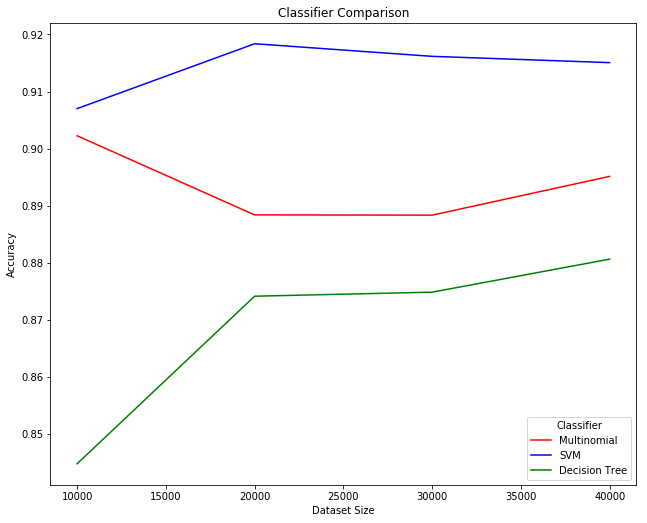

In [9]:
# Plot results from Bayesian, Decision Tree and SVM
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(10.5, 8.5)

plt.title('Classifier Comparison')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
#plt.yticks([i  for i in range(10)])

plt.plot([k for k in bayesian_results.keys()], [ v for v in bayesian_results.values()], color='red')
plt.plot( [k for k in svm_results.keys()], [ v for v in svm_results.values()], color='blue')
plt.plot( [k for k in decision_results.keys()], [ v for v in decision_results.values()], color='green')

plt.legend(['Multinomial', 'SVM', 'Decision Tree'], title='Classifier')
plt.show()
fig.savefig('classifier-comparison.png')

In [10]:
print(happy_tweets[0])
print(sad_tweets[0])

('fuckoff theme love night party horror black candy music halloween bestoftheday celebrate smile instafun memories instalike instaparty guys love white partytime crazy theme ghost cool outfit fuck', 1)
('meme', 0)


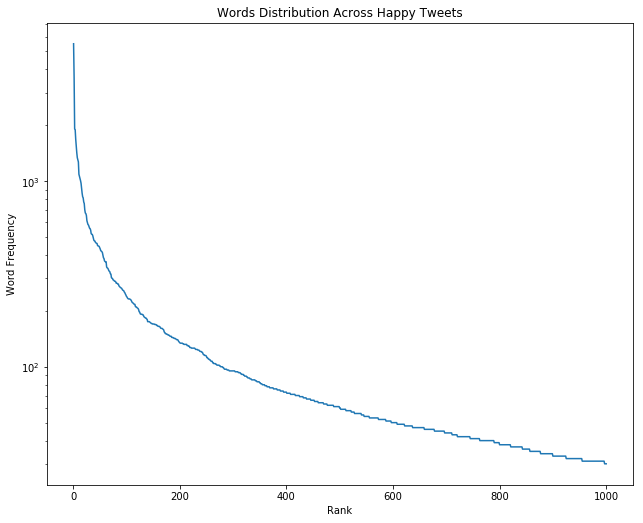

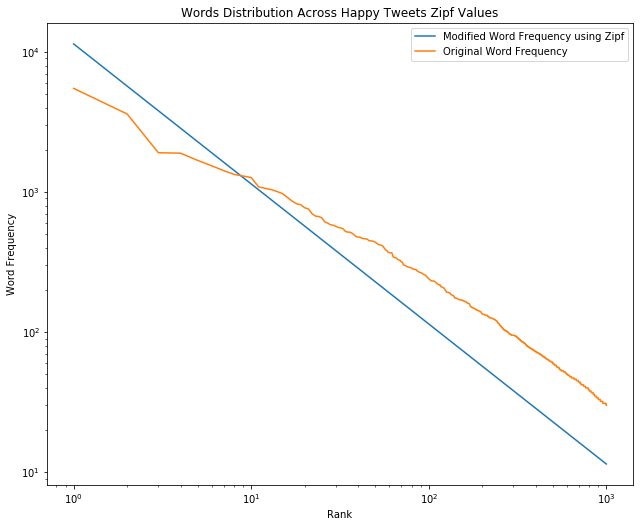

In [29]:
from collections import OrderedDict
from operator import itemgetter

# print top 10 frequent happy words
def getWordsCount(tweets_col):
    w_dict = {}
    for tw, label in tweets_col:
        w_list = tw.split()
        for w in w_list:
            if w not in w_dict.keys():
                w_dict[w] = 1
            else:
                w_dict[w] = w_dict[w] + 1
    return w_dict

def drawCharts(tw_col, tw_col_count, title):
    #For plotting graph
    import matplotlib.pyplot as plt
    
    rank = [i+1 for i in range(1000)] #To print rank in the graph for X-axis
    
    fig = plt.figure()
    fig.set_size_inches(10.5, 8.5)    
    plt.plot(rank, tw_col_count)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Rank')
    plt.ylabel('Word Frequency')
    plt.show()
    fig.savefig('word-freq'+title+'.png')
    
    #Now using Zipf's law:- f = a/(b * r)
    #Ran the equations many times and decided to use the following constant values
    a = 4
    b = 0.00035
    zipf_value = [(a / (b * r)) for r in rank]
    
    fig = plt.figure()
    fig.set_size_inches(10.5, 8.5)
    plt.plot(rank, zipf_value)
    plt.plot(rank, tw_col_count)  #To show both lines side-by-side
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Word Frequency')
    plt.title( title +' Zipf Values')
    plt.legend(['Modified Word Frequency using Zipf','Original Word Frequency'])
    plt.show()
    fig.savefig('Modified-word-freq'+title+'.png')
    

hw_dict = getWordsCount(happy_tweets)
hw_dict_desc = OrderedDict(sorted(hw_dict.items(),  key=itemgetter(1), reverse = True))
#print(hw_dict_desc)

#For top 1000 words
hw1000 = []
hw1000Count = []

iter = 1
for words, wcount in hw_dict_desc.items():
    hw1000.append(words)
    hw1000Count.append(wcount)
    if iter == 1000:
        break
    iter = iter + 1
    
drawCharts(hw1000, hw1000Count, 'Words Distribution Across Happy Tweets')


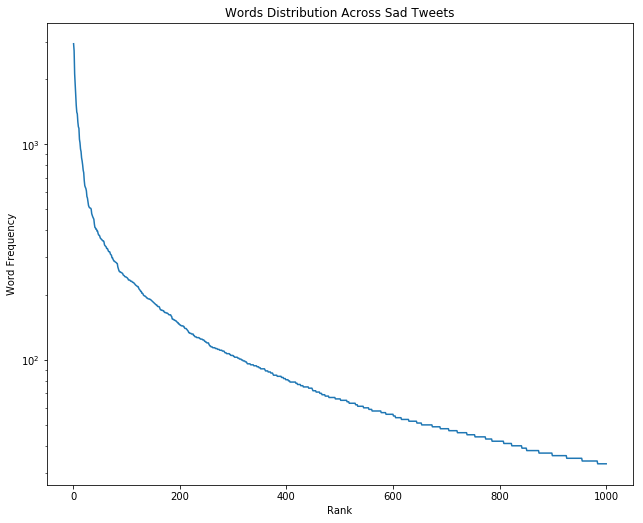

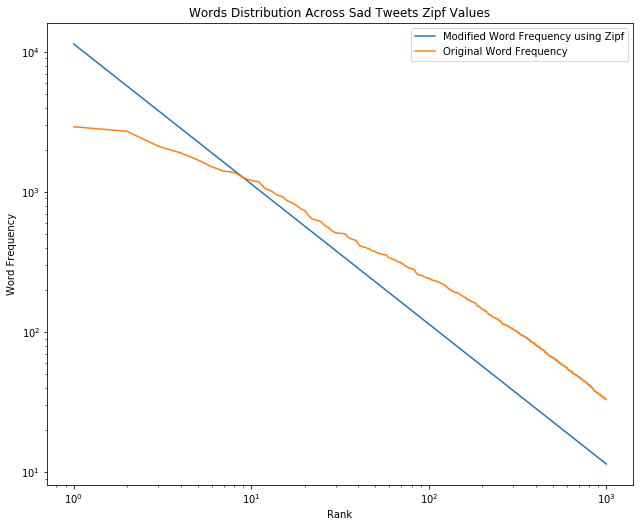

In [33]:
sw_dict = getWordsCount(sad_tweets)
sw_dict_desc = OrderedDict(sorted(sw_dict.items(),  key=itemgetter(1), reverse = True))
#print(sw_dict_desc)

#For top 1000 words
sw1000 = []
sw1000Count = []

iter = 1
for words, wcount in sw_dict_desc.items():
    sw1000.append(words)
    sw1000Count.append(wcount)
    if iter == 1000:
        break
    iter = iter + 1

drawCharts(sw1000, sw1000Count, 'Words Distribution Across Sad Tweets')
